#프로젝트

### Step 1. 형태소 분석기 변경해 보기
한국어 자연어 처리에 성능에 영향을 주는 또 다른 요소는 사용하는 형태소 분석기의 종류입니다. 앞서 진행한 프로젝트에서는 Mecab을 사용했었습니다. 하지만 이번에 설치한 konlpy 패키지 안에는 Mecab 이외에도 Hannanum, Kkma, Komoran, Okt 라는 형태소분석기가 존재합니다. 이들 형태소 분석기 중 어떤 것을 선택하는 것이 좋을지, 형태소 분석기간의 장단점은 무엇인지, 처리 속도와 성능에는 어떤 변화가 있는지 비교해 보세요.


### Step 2. 불용어 추가해 보기
머신 러닝을 하다보면 전처리는 어쩌면 끝이 없는 작업일 수도 있습니다. 불용어 추가도 마찬가지입니다. 데이터를 출력해 보고, 직접 뉴스를 열어보면서 불용어가 총 50개가 될 때까지 추가해 보세요. 그리고 불용어를 추가하기 전, 후의 모델 성능을 비교해 보세요.

지나치게 빈도가 낮은 단어, 지나치게 빈도가 높은 단어 둘 중 어떤 단어가 불용어로 선택할 경우에 모델 성능 향상에 효과가 더 좋을지도 고민해 봅시다.

### Step 3. 다른 날짜 데이터 추가해 보기
동일한 날짜에는 그 날 특정 사건이 일어나서 비슷한 뉴스들이 올라왔을 가능성이 많습니다. 사실 좀 더 정확한 모델을 만들기 위해서는 다른 날짜의 뉴스들도 훈련 데이터로 사용하는 것이 좋을 겁니다.

크롤링을 위한 코드는 이미 주어졌습니다. 이제는 2020년 5월 6일 외에도 다른 일자의 데이터를 좀 더 추가해 보겠습니다. 이미 수집한 2020년 5월 6일 데이터와 추가로 수집된 데이터를 적절히 합치려면 어떻게 해야할까요? 또 어떻게 해야 적절히 데이터를 섞을 수 있을까요? 한번 고민해서 데이터를 수집해 보세요.

[안녕](#동일


#### library import

In [33]:
# import library


import requests
import pandas as pd
from bs4 import BeautifulSoup
from newspaper import Article
import os

# 형태소 분석기
from konlpy.tag import Hannanum
from konlpy.tag import Kkma
from konlpy.tag import Komoran
from konlpy.tag import Okt
from konlpy.tag import Mecab

#머신러닝...
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics



#### 데이터 추출 

In [34]:
##### 데이터 추출 함수 정의

In [35]:


# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)   
    news = requests.get(url)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    #print(news_list)
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.text)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

def make_total_data(page_num, code_list, date):
    df = None

    for code in code_list:
        url_list = make_urllist(page_num, code, date) #BeautifulSoup select
        df_temp = make_data(url_list, code) #newspaer title conntent export
        print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

        if df is not None:
          df = pd.concat([df, df_temp]) # date 연결 이어 붙임 
        else:
          df = df_temp

    return df

#### 추출한 데이터 csv 파일로 저장

- 이미 제공된 파일로 대체 주석처리..


In [36]:
# 아래 주석처리된 코드의 주석을 해제하고 실행을 하면 대량 크롤링이 진행됩니다. 
# 위에서 수행했던 크롤링의 100배 분량이 수행될 것입니다. 한꺼번에 너무 많은 크롤링 요청이 서버에 전달되지 않도록 주의해 주세요. 
# 기사 일자를 바꿔보면서 데이터를 모으면 더욱 다양한 데이터를 얻을 수 있게 됩니다. 

#df = make_total_data(100, code_list, 20200506)

# 

# # 데이터프레임 파일을 csv 파일로 저장합니다.
# # 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.

# csv_path = os.getenv("./news_data.csv")

# df.to_csv(csv_path, index=False)

# if os.path.exists(csv_path):
#   print('{} File Saved!'.format(csv_path))

#### 데이터 정제

In [37]:
csv_path = "./news_data2.csv" #파일 path
df = pd.read_table(csv_path, sep=',')  #파일 읽어드리기
df.head()

,news,code
0,기사 섹션 분류 안내\n\n기사의 섹션 정보는 해당 언론사의 분류를 따르고 있습니다...,경제
1,▶제21대 총선 실시간 개표 현황 및 결과 보기\n\n총선에서 여당이 다시 한 번 ...,경제
2,[뉴욕=AP/뉴시스]지난 10일 뉴욕 증권거래소 건물에 미국 국기가 게양되어 있다....,경제
3,"부산지역 주유소에서 판매하는 기름값이 휘발유는 평균 1200원대, 경유는 1000원...",경제
4,담배업계가 소비자의 취향을 저격한 다양한 담배 신제품들을 잇달아 선보이고 있다.이전...,경제


#### 한글 외 특수만자, 개행문자 등 제거

In [38]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
# 개행 문자....
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

0       기사 섹션 분류 안내기사의 섹션 정보는 해당 언론사의 분류를 따르고 있습니다 언론사...
1       제대 총선 실시간 개표 현황 및 결과 보기총선에서 여당이 다시 한 번 승리를 거두면...
2       뉴욕뉴시스지난 일 뉴욕 증권거래소 건물에 미국 국기가 게양되어 있다 신종 코로나바이...
3       부산지역 주유소에서 판매하는 기름값이 휘발유는 평균 원대 경유는 원대에 돌입했다일 ...
4       담배업계가 소비자의 취향을 저격한 다양한 담배 신제품들을 잇달아 선보이고 있다이전까...
                              ...                        
3698    레고켐바이오사이언스대표 김용주사진가 글로벌 기술수출에 또다시 성공했다 년 중국 포순...
3699    제대 국회의원선거 기간 중단됐던 네이버 실시간 급상승 검색어 서비스가 일 오후 시부...
3700    아마존 연합뉴스 자료사진 아마존 연합뉴스 자료사진직원들 코로나 확산 방지 조치 충분...
3701    제대 국회의원선거가 임박한 가운데 투표 및 개표 방송을 준비하는 기업들의 움직임이 ...
3702    롤 점검이 일 진행될 예정이다온라인게임 리그오브레전드이하 롤은 일 오전 시부터 오전...
Name: news, Length: 3703, dtype: object

#### 데이터 체크

In [39]:
# null 값 개수 조회
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [40]:
# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df)

SyntaxError: unexpected EOF while parsing (<ipython-input-40-fc659a0f5b56>, line 4)

#### 데이터 탐색

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home

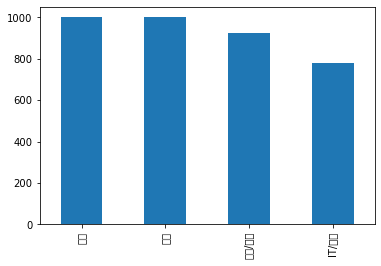

In [41]:
df['code'].value_counts().plot(kind = 'bar')

In [42]:
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학    778
1     경제   1000
2     사회   1000
3  생활/문화    925


#### 토큰화 (mecab) ,  형태소 분석 토큰화 및 불용어 제거

In [92]:
#형태소 분석기 정하기

tokenizer = Mecab()
#tokenizer = Hannanum()
#tokenizer = Komoran()
#tokenizer = Okt()

#Hannanum, Kkma, Komoran, Okt

# 불용어
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']


#불용어 추가
#stopwords.extend(['가', '기자'])

TypeError: startJVM() got an unexpected keyword argument 'convertStrings'

In [91]:
# 토큰화 함수 정의
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [83]:
# 토큰화 실행
text_data = preprocessing(df['news'])
print(text_data[0])

기사 섹션 분류 안내 기사 섹션 정보 해당 언론사 분류 를 따르 고 습니다 언론사 개별 기사 를 개 이상 섹션 으로 중복 분류 습니다 닫 기


#### 훈련 데이터 테스트 데이터 정의

In [84]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

In [85]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 2777
테스트용 뉴스 기사의 개수 :  926
훈련용 레이블의 개수 :  2777
테스트용 레이블의 개수 :  926


In [86]:
#### 텍스트를 입력하면 자동으로 TF-IDF 벡터로 바꾸는 전처리 함수

In [87]:

def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

#### 단어수 카운트 및 백터라이져 TF-IDF , 나이브 베이즈 분류기 수행

In [88]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
# 단어 데이터를 학습하고 문서 데이터를 document-form matrix로 변환하는 두 가지 작업을 해 줍니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#print(X_train_counts)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#print(X_train_tfidf)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)


#### 모델을 예측하게하고, 실제값과 비교하여 점수를 측정

In [89]:
#

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.91      0.83      0.87       213
          경제       0.79      0.86      0.83       263
          사회       0.81      0.96      0.88       242
       생활/문화       0.93      0.72      0.81       208

    accuracy                           0.85       926
   macro avg       0.86      0.84      0.85       926
weighted avg       0.86      0.85      0.85       926



In [96]:
#형태소 분석기 정하기

t = Okt()
#tokenizer = Mecab()
tokenizer = Hannanum()
#tokenizer = Komoran()
#tokenizer = Okt()

#Hannanum, Kkma, Komoran, Okt

# 불용어
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']


#불용어 추가
#stopwords.extend(['가', '기자'])

TypeError: startJVM() got an unexpected keyword argument 'convertStrings'